In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle as pkl

In [2]:
seed = 2
path2data = '/home/nina/CopulaGP/examples/shuttle'
exp = f'shuttle{seed}'
g = ''
path_data = lambda layer: f"{path2data}/outputs/{exp}{g}_layer{layer}.pkl"
path_models = lambda layer: f"{path2data}/outputs/{exp}{g}_models_layer{layer}.pkl"
path_final = f"{path2data}/outputs/{exp}{g}_trained.pkl"

In [3]:
with open(path_data(0),'rb') as f:
    data = pkl.load(f)
data.keys()

dict_keys(['X', 'Xt', 'Y', 'Yt', 'X_label'])

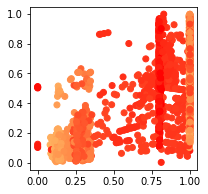

In [4]:
X = data['X']
Y = data['Y'][:,[2,0]]

import matplotlib.cm as cm

plt.figure(figsize=(3,3))
skip = 2
plt.scatter(*Y[X>0.75,:].T,color=cm.rainbow(X[X>0.75]))

In [5]:
import sys
sys.path.insert(0, '../../')
import bvcopula

In [6]:
import torch
import numpy as np
import time
from torch import Tensor
from matplotlib import pyplot as plt
import logging
from gpytorch.mlls import VariationalELBO
from gpytorch.settings import num_likelihood_samples
import gc

import bvcopula
from utils import get_copula_name_string
from bvcopula import conf

def infer(bvcopulas, train_x: Tensor, train_y: Tensor, device: torch.device,
            output_loss=None, grid_size=None):

    if device!=torch.device('cpu'):
        with torch.cuda.device(device):
            torch.cuda.empty_cache()

    logging.info('Trying {}'.format(get_copula_name_string(bvcopulas)))

    # define the model (optionally on GPU)
    model = bvcopula.Pair_CopulaGP(bvcopulas,device=device,grid_size=grid_size)

    optimizer = torch.optim.Adam([
        {'params': model.gp_model.mean_module.parameters()},
        {'params': model.gp_model.variational_strategy.parameters()},
        {'params': model.gp_model.covar_module.parameters(), 'lr': conf.hyper_lr}, #hyperparameters
    ], lr=conf.base_lr)
    
    # train the model

    mll = VariationalELBO(model.likelihood, model.gp_model,
                            num_data=train_y.size(0))
    
    losses, rbf, means = [], [], []

    nans_detected = 0
    WAIC = -1 #assume that the model will train well

    def train(train_x, train_y, num_iter=conf.max_num_iter):
        model.gp_model.train()
        model.likelihood.train()

        loss_gpu = torch.zeros(num_iter,device=device)

        p = torch.zeros(1,device=device)
        nans = torch.zeros(1,device=device)
        for i in range(num_iter):
            optimizer.zero_grad()
            output = model.gp_model(train_x)

            with num_likelihood_samples(30):
                loss = -mll(output, train_y)  

            if i>2*conf.loss_av: 
                p += (loss_gpu[i-conf.loss_av:i].mean() - 
                      loss_gpu[i-2*conf.loss_av:i-conf.loss_av].mean()).abs()
            loss_gpu[i] = loss.detach()

            if not (i + 1) % conf.iter_print:

                losses.append(loss.detach().cpu().numpy())
                rbf.append(model.gp_model.covar_module.base_kernel.lengthscale.detach().cpu().numpy().squeeze())
                means.append(model.gp_model.variational_strategy.base_variational_strategy._variational_distribution.variational_mean.detach().cpu().numpy())

                mean_p = p/conf.loss_av/2
                av_loss = loss_gpu[i-2*conf.loss_av:i].mean().abs().cpu()
                print(f"{i}: {mean_p}, {mean_p/av_loss}")

                if (mean_p < conf.loss_tol2check_waic):
                    WAIC = model.likelihood.WAIC(model.gp_model(train_x),train_y)
                    if (WAIC > conf.waic_tol):
                        print("Training does not look promissing!")
                        break

                if (mean_p < conf.a_loss_tol) or (mean_p/av_loss < conf.r_loss_tol):
                    print("Converged in {} steps!".format(i+1))
                    break
                p = 0.
                
                for param_group in optimizer.param_groups:
                    param_group['lr'] = param_group['lr']*0.8

            # The actual optimization step
            loss.backward()
            covar_grad = model.gp_model.variational_strategy.base_variational_strategy._variational_distribution.chol_variational_covar.grad
            # strict
            # assert torch.all(covar_grad==covar_grad)
            #light
            if torch.any(covar_grad!=covar_grad):
                for n, par in model.gp_model.named_parameters():
                    grad = par.grad.data
                    if torch.any(grad!=grad):
                        # print('NaN grad in {}'.format(n))
                        nans_detected = 1
                    # nans+=torch.sum(grad!=grad)
                    if torch.any(grad.abs()==float('inf')):
                        logging.warning("Grad inf... fixing...")
                        grad = torch.clamp(grad,-1.,1.)
                    grad[grad!=grad] = 0.0
                    par.grad.data = grad
            optimizer.step()

    t1 = time.time()

    if (len(bvcopulas)!=1) or (bvcopulas[0].name!='Independence'):
        train(train_x,train_y)

    if nans_detected==1:
        logging.warning('NaNs were detected in gradients.')

    if output_loss is not None:
        assert isinstance(output_loss, str)
        plot_loss(output_loss, losses, rbf, means)

    if (WAIC < 0): 
    # if model got to the point where it was better than independence: recalculate final WAIC
        WAIC = model.likelihood.WAIC(model.gp_model(train_x),train_y)

    t2 = time.time()
    print('WAIC={:.4f}, took {} sec'.format(WAIC,int(t2-t1)))

    if device!=torch.device('cpu'):
        with torch.cuda.device(device):
            torch.cuda.empty_cache()

    gc.collect()

    return WAIC, model, losses


In [7]:
likelihoods = [bvcopula.GaussianCopula_Likelihood(),
               bvcopula.ClaytonCopula_Likelihood()
]
device='cuda:0' # can be cuda, but no need for this here
train_x = torch.tensor(X, device=device).float()
train_y = torch.tensor(Y, device=device).float()
waic, model, losses = infer(likelihoods, train_x, train_y, device)

99: tensor([0.0133], device='cuda:0'), tensor([0.4384], device='cuda:0')
199: 0.0016608983278274536, 0.04904868081212044
299: 0.0008170632645487785, 0.023008884862065315
399: 0.000714528898242861, 0.019345851615071297
499: 0.0004843926290050149, 0.012780855409801006
599: 0.00029513597837649286, 0.0076655554585158825
699: 0.00021509549696929753, 0.0055239577777683735
799: 0.00017175040557049215, 0.004373952280730009
Converged in 800 steps!
WAIC=-0.0408, took 115 sec


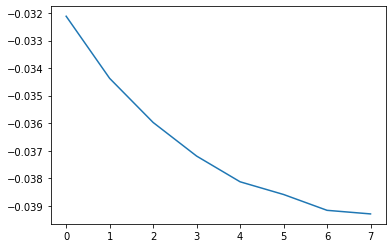

In [8]:
plt.plot(losses)
# losses

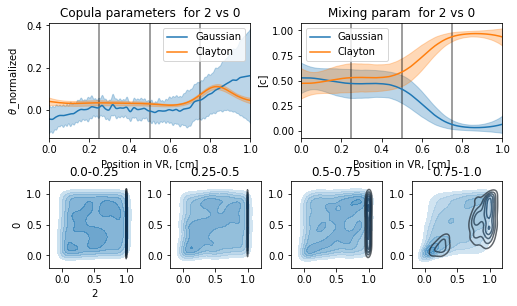

In [9]:
from utils import Plot_Fit
Plot_Fit(model, X, Y, '2', '0', device, order = None);

In [10]:
waic

-0.04078463464975357

In [11]:
0.0005/0.039

0.01282051282051282

In [12]:
np.diff(np.array(losses))/np.array(losses[1:])

array([0.06561743, 0.04450098, 0.03280821, 0.02449023, 0.01195293,
       0.01468035, 0.00331731], dtype=float32)